In [59]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import os
import torch
import random
import json
import datetime
import time

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 
from heapq import nlargest

tqdm.pandas()

In [2]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
skills = dict(zip(skills.index, skills.values))

In [4]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
certs = dict(zip(certs.index, certs.values))

In [6]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [7]:
licenses = dict(zip(licenses.index, licenses.values))

In [8]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
languages = dict(zip(languages.index, languages.values))

In [10]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,90
84612,48
84731,3766
85437,3812
85627,1556


In [11]:
addresses = dict(zip(addresses.index, addresses.values))

In [12]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [13]:
df_pred = pd.read_csv("../Data/df_pred_ext.csv").drop("Unnamed: 0", axis=1)

In [14]:
df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()

In [15]:
df_pred.head()

,candidate_id,job_order,time_between,time_spent,isco_functie_niveau,source,education,company_name,function_id,isco_code4
0,84556,0,-0.292887,-0.210459,2.0,0,0.0,324258,936,208
1,84556,1,-0.306568,-0.252626,1.0,0,0.0,324258,809,348
2,84556,2,-0.306568,-0.085012,2.0,0,0.0,329244,936,208
3,84556,3,0.799670,-0.370694,1.0,0,0.0,368140,1519,344
4,84556,4,-0.130664,-0.363314,1.0,0,0.0,419826,1519,344


In [16]:
df_pred["company_name"].max()

441152

In [17]:
majority_class = df_pred["isco_code4"].mode().values[0]

<AxesSubplot:>

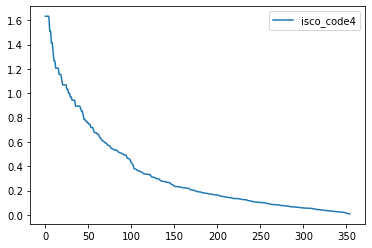

In [18]:
(2 / (0.5 * np.sqrt(df_pred["isco_code4"].value_counts().sort_values().reset_index().drop("index", axis=1)))).plot()

In [19]:
career_paths = df_pred.groupby("candidate_id")

In [20]:
candidate_lens = career_paths.apply(lambda x: len(x) - 1).to_dict()

In [21]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 9)

In [22]:
maximum_career_duration = 25

In [23]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:49<00:00, 9432.55it/s]


In [24]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [25]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [26]:
career_paths.head()

candidate_id
84556    [[0.0, -0.292886688151019, -0.2104587010204839...
84612    [[0.0, 2.150219165944193, -0.3685852264755267,...
84731    [[0.0, -0.28409150707627623, -0.35066422025728...
85437    [[0.0, 0.4009553744120213, 0.3313881928721292,...
85888    [[0.0, -0.23816111701928622, -0.28952196374800...
dtype: object

In [27]:
idxs = []
x = []
y = []

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):       
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [28]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [29]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [30]:
del df_pred
del x

In [31]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [32]:
# Filtered: (113428, 113428)
# Grouped: (176485, 176485)
len(to_fill), len(y)

(113724, 113724)

In [33]:
# to_fill = to_fill[:50000]
# y = y[:50000]

In [34]:
def create_loaders(to_fill, idxs, y, split_size=0.8, weight_type=3, batch_size=512):

    # Train test split
    split = split_size

    training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
    test = np.array(list(set(range(len(to_fill))) - set(training)))

    train_indices, val_indices = idxs[training], idxs[test]
    X_train, X_val = to_fill[training], to_fill[test]
    y_train, y_val = y[training].astype(int), y[test].astype(int)

    # Class weights
    counts = (np.bincount(y_train) + 1)
    
    if weight_type == 1:
        labels_weights = 1. / counts
    elif weight_type == 2:
        labels_weights = 1. / np.sqrt(counts)
    elif weight_type == 3:
        labels_weights = 2. / (0.5 * np.sqrt(counts))
    else:
        return NotImplemented
        
    weights = labels_weights[y_train]
    sampler = WeightedRandomSampler(weights, len(weights))

    # Create dataloaders
    train_data = TensorDataset(torch.Tensor(train_indices), 
                               torch.Tensor(X_train), 
                               torch.Tensor(y_train).type(torch.LongTensor))

    trainloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

    val_data = TensorDataset(torch.Tensor(val_indices),
                             torch.Tensor(X_val),
                             torch.Tensor(y_val).type(torch.LongTensor))

    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    return trainloader, valloader

In [81]:
class HCPNN(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, 
                 num_layers, skills, certs, licenses, languages, 
                 addresses, w2v, candidate_lengths, max_len, dropout_prob=0.3,
                 skill_embedding_size=50, certs_embedding_size=20,
                 license_embedding_size=3, language_embedding_size=10,
                 address_embedding_size=25, function_embedding_size=50, 
                 isco4_embedding_size=25, education_embedding_size=3, 
                 isco_level_embedding_size=3, company_embedding_size=50):
        
        super(HCPNN, self).__init__()
              
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size + 300
        self.hidden_size = hidden_size
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        
        # Address embedding
        self.address_embedding = nn.Embedding(4757, address_embedding_size)       
        
        # Categorical feature embeddings isco_functie_niveau	source	education	company_name	function_id	isco_code4
        self.function_embedding = nn.Embedding(2993, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.source_embedding = nn.Embedding(2, 1)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
        
        self.LSTMs = nn.ModuleList()
        
        for i in range(num_layers):
            # input size + embedding
            input_size = self.input_size + (function_embedding_size + isco4_embedding_size + company_embedding_size + 1 +
                                            education_embedding_size + isco_level_embedding_size - 6) if i == 0 else hidden_size
                                                  
            self.LSTMs.append(nn.LSTM(input_size=input_size,
                                      hidden_size=hidden_size,
                                      num_layers=1,
                                      batch_first=True))
            
        # Attention layer
        self.att_fc = nn.Linear(hidden_size, 1)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # Final fully-connected layer takes the LSTM output, as well as the static embeddings
        self.fc = nn.Linear(hidden_size + skill_embedding_size + certs_embedding_size + license_embedding_size + 
                            language_embedding_size + address_embedding_size, num_classes)
        
        self.softmax = nn.LogSoftmax(dim=-1)

        # Skill lookup
        self.skills = skills
        
        # Certificate lookup
        self.certs = certs
        
        # License lookup
        self.licenses = licenses
        
        # Language lookup
        self.langs = languages
        
        # Address lookup
        self.adds = addresses
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len      
        
        def get_from_dict(x, cdict, N):
            return cdict.get(x, np.zeros((N,)))

        self.retrieve_static = np.vectorize(get_from_dict, otypes=[np.ndarray])
                
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        actual_career_duration = career_duration
        career_duration = min(career_duration, max_len)
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.LongTensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                
                to_skip = 0
                                
                # Make sure to use candidates' most recent max_len cvs
                if actual_career_duration > self.max_len:
                    # 0, 10, 20, 30, 40, 50
                    # duration = 50
                    # ---> 0, 5, 15, 25
                                        
                    # Update to only include most recent max_len
                    ks -= max_len
                    
                    # Drop everything older than max_len time steps
                    ks_2 = np.array([ks[i] for i in range(len(ks)) if i < len(ks) and (i + 1 >= len(ks) or ks[i + 1] > 0)])
                    
                    # Store how many we need to skip while indexing
                    to_skip = len(ks) - len(ks_2)
                    
                    # Update ks
                    ks = ks_2
                    ks[0] = 0
                    
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= min(self.max_len, career_duration)])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        # Figure out negative duration cause
                        storage.append(torch.stack([torch.Tensor(embed_values[i + to_skip])] * duration, dim=0))
                else:
                    w2v_list = torch.LongTensor(cvs[0]).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * 300).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
    
    def attention(self, outputs):
        
        # Deal with batches 
        outputs = outputs.transpose(0, 1)
        att_weight = []
        
        # Determine weight of each timestep
        for timestep in outputs:
            x = self.att_fc(timestep)
            att_weight.append(x)
                        
        # Normalize            
        normalized_weights = nn.functional.softmax(torch.cat(att_weight, 1), 1)
        
        # Transpose to match normalized_weights
        outputs = outputs.transpose(0, 1)
        outputs = outputs.transpose(1, 2)
        
        # Multiply each timestep by its weight
        attn_applied = outputs * normalized_weights.unsqueeze(1)
        
        # Weighted sum over time steps
        attn_applied = attn_applied.sum(dim=2)
        
        return attn_applied, normalized_weights
 
    def forward(self, candidate, x):               
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * 300).type(torch.LongTensor).to(device)
        
        candidate_features = []
        
        skill_list = self.retrieve_static(candidate, self.skills, 317)
        skill_list = torch.LongTensor(np.stack(skill_list)).to(device)
        
        certs_list = self.retrieve_static(candidate, self.certs, 98)
        certs_list = torch.LongTensor(np.stack(certs_list)).to(device)
        
        license_list = self.retrieve_static(candidate, self.licenses, 8)
        license_list = torch.LongTensor(np.stack(license_list)).to(device)
        
        langs_list = self.retrieve_static(candidate, self.langs, 23)
        langs_list = torch.LongTensor(np.stack(langs_list)).to(device)
            
        address = self.retrieve_static(candidate, self.adds, 1)
        address = torch.LongTensor(np.stack(address)).to(device)
        
        # Embed every static feature
        skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                            self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                            self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                            self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
        
        # Combine and embed
        batch_features = torch.cat([skill_list, certs_list, 
                                    license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
        batch_addresses = self.address_embedding(address)[:,0,:]
                
        # For each candidate in the current batch
        for i, c in enumerate(candidate):
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]
                        
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)
            
            # Reset to max_len
            career_duration = min(career_duration, max_len)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([feature_width] * (self.max_len - career_duration))
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                                    
            # Broadcast CV, static, and address to the correct length
            full_features = torch.cat([zeros, w2v_list], dim=0)
                    
            # Store result
            candidate_features.append(full_features)
                                
        # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
                
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, source, education, company_name, function_id, isco_code = [x[:,:,-6],
                                                                               x[:,:,-5],
                                                                               x[:,:,-4],
                                                                               x[:,:,-3],
                                                                               x[:,:,-2],
                                                                               x[:,:,-1]]
        
        x = x[:,:,:-6].to(device)
        
        isco_level_smoothing = (isco_level != 0).unsqueeze(-1)
        source_smoothing = (source != 0).unsqueeze(-1)
        education_smoothing = (education != 0).unsqueeze(-1)
        company_name_smoothing = (company_name != 0).unsqueeze(-1)
        function_id_smoothing = (function_id != 0).unsqueeze(-1)
        isco_code_smoothing = (isco_code != 0).unsqueeze(-1)
        
        isco_level, source, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)) * isco_level_smoothing,
                                                                                self.source_embedding(source.type(torch.LongTensor).to(device)) * source_smoothing,
                                                                                self.education_embedding(education.type(torch.LongTensor).to(device)) * education_smoothing,
                                                                                self.company_embedding(company_name.type(torch.LongTensor).to(device)) * company_name_smoothing,
                                                                                self.function_embedding(function_id.type(torch.LongTensor).to(device)) * function_id_smoothing,
                                                                                self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device)) * isco_code_smoothing]   
                
        # Add features
        x = torch.cat([x, isco_level, source, education, company_name, function_id, isco_code, additional_features], dim=2)
        
        outputs = []
        
        # Forward pass
        for i in range(self.num_layers):
            # All hidden state, last hidden state, last cell state
            output, (_, _) = self.LSTMs[i](self.dropout(x))
            outputs.append(output)
            x = output # self.dropout(output)
            
        # Apply attention
        # TODO: Authors apply attention to static features too? 
        output, weight = self.attention(x)
        
        # Combine attention output with static features
        # TODO: this could be messy, as scales could be different
        x = torch.cat([output, batch_features, batch_addresses], dim=1)
                        
        # Fully-connected
        out = self.fc(x)

        # softmax
        out = self.softmax(out)
                        
        return out, weight

In [109]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0
        
        for i, (candidate, career, job) in enumerate(trainloader):
            career, job = career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs, weight = model(candidate, career)
                        
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
                                
        training_loss /= len(trainloader)
               
        stats = test_loop(valloader, model, criterion)
        
        done = int(time.time() - start)        
        print(f"Epoch duration: {int((done) // 60)}:{int((done) % 60):02d}")

        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        results["training_loss"].append(training_loss)
        results["duration"].append(done)
        
        with open(f"../logs/LSTM/{datetime.now().strftime('%Y_%d_%m_%H:%M:%S')}.txt", "w+") as f:
            f.write(f"{model}\n\nEpoch: {epoch + 1}\n\nAcc@1: {stats[0]}\n\nDuration: {int(done // 60)}:{int(done % 60):02d}")
        
        scheduler.step()
                
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
        
        plt.plot(passed, training_losses, label="Training Loss")
        plt.plot(passed, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.legend()
        plt.show()
                
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            career, job = career.to(device), job.to(device)
            pred, weight = model(candidate, career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
            
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}")
    
    return acc1, acc5, acc10, acc20, test_loss

In [110]:
torch.cuda.empty_cache()

In [111]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

Current iteration 0/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 500, batch_first=True)
  )
  (att_fc): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=608, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

----------------------------------------------------------------------

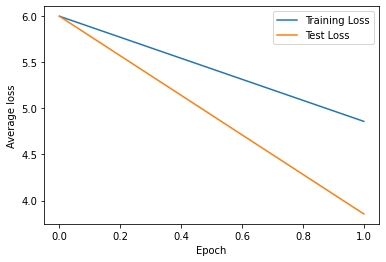

-------------------------------------------------------------------------------
Epoch starting at: 20:30:26
Epoch: 2, batch: 178/178, loss: 3.52790
Test Error:
Acc@1: 18.88%, Acc@5: 46.92%, Acc@10: 60.51%, Acc@20: 73.50% Avg loss: 3.671326
Epoch duration: 1:25


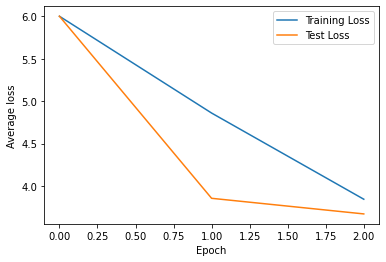

-------------------------------------------------------------------------------
Epoch starting at: 20:31:52
Epoch: 3, batch: 178/178, loss: 2.67497
Test Error:
Acc@1: 19.75%, Acc@5: 47.54%, Acc@10: 60.94%, Acc@20: 73.89% Avg loss: 3.616603
Epoch duration: 1:27


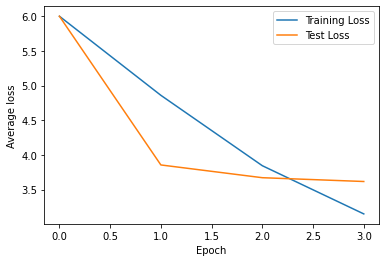





Current iteration 1/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 500, batch_first=True)
  )
  (att_fc): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=608, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

---------------------------------------------------------------

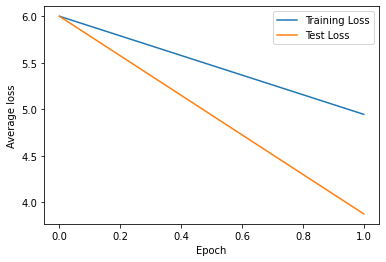

-------------------------------------------------------------------------------
Epoch starting at: 20:34:47
Epoch: 2, batch: 178/178, loss: 3.67464
Test Error:
Acc@1: 19.70%, Acc@5: 47.53%, Acc@10: 59.80%, Acc@20: 72.50% Avg loss: 3.702973
Epoch duration: 1:27


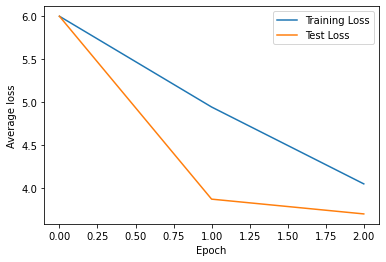

-------------------------------------------------------------------------------
Epoch starting at: 20:36:15
Epoch: 3, batch: 178/178, loss: 3.16974
Test Error:
Acc@1: 19.10%, Acc@5: 46.12%, Acc@10: 59.56%, Acc@20: 72.39% Avg loss: 3.679106
Epoch duration: 1:25


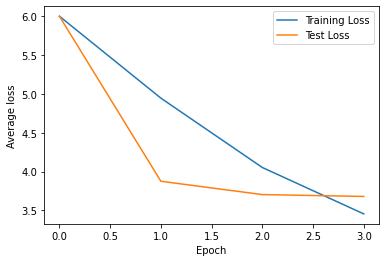





Current iteration 2/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 500, batch_first=True)
  )
  (att_fc): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=608, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

----------------------------------------------------------------

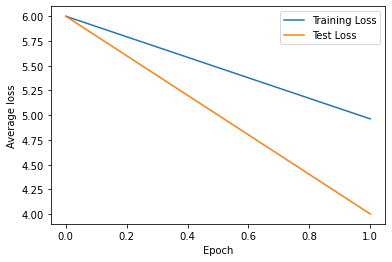

-------------------------------------------------------------------------------
Epoch starting at: 20:39:08
Epoch: 2, batch: 178/178, loss: 3.92070
Test Error:
Acc@1: 18.15%, Acc@5: 46.14%, Acc@10: 59.89%, Acc@20: 73.01% Avg loss: 3.748198
Epoch duration: 1:26


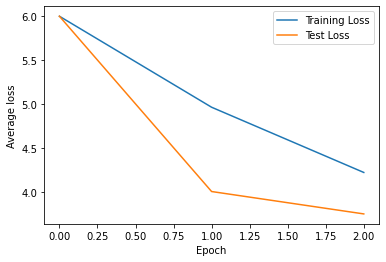

-------------------------------------------------------------------------------
Epoch starting at: 20:40:35
Epoch: 3, batch: 178/178, loss: 3.75026
Test Error:
Acc@1: 17.80%, Acc@5: 45.40%, Acc@10: 59.37%, Acc@20: 72.71% Avg loss: 3.733133
Epoch duration: 1:27


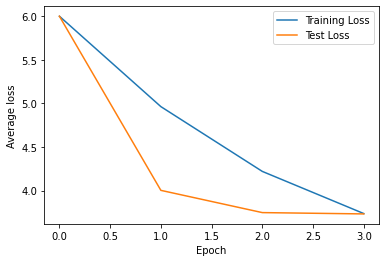





Current iteration 3/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 500, batch_first=True)
  )
  (att_fc): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.75, inplace=False)
  (fc): Linear(in_features=608, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

---------------------------------------------------------------

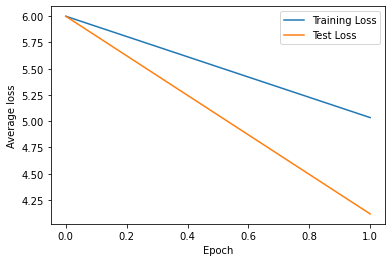

-------------------------------------------------------------------------------
Epoch starting at: 20:43:30
Epoch: 2, batch: 178/178, loss: 4.30166
Test Error:
Acc@1: 17.78%, Acc@5: 44.64%, Acc@10: 57.50%, Acc@20: 70.73% Avg loss: 3.947104
Epoch duration: 1:27


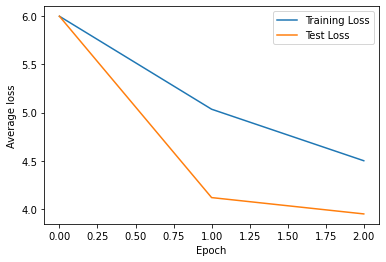

-------------------------------------------------------------------------------
Epoch starting at: 20:44:57
Epoch: 3, batch: 178/178, loss: 4.03110
Test Error:
Acc@1: 16.68%, Acc@5: 44.16%, Acc@10: 57.61%, Acc@20: 70.92% Avg loss: 3.879702
Epoch duration: 1:27


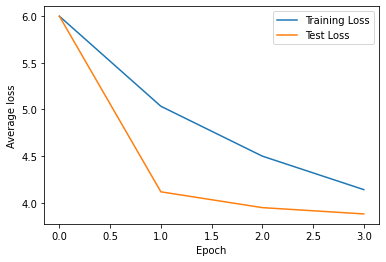





Current iteration 4/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 1000, batch_first=True)
  )
  (att_fc): Linear(in_features=1000, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=1108, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

---------------------------------------------------------------

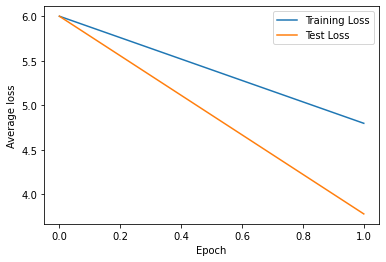

-------------------------------------------------------------------------------
Epoch starting at: 20:48:28
Epoch: 2, batch: 178/178, loss: 3.07556
Test Error:
Acc@1: 19.24%, Acc@5: 47.44%, Acc@10: 60.74%, Acc@20: 72.95% Avg loss: 3.652411
Epoch duration: 2:01


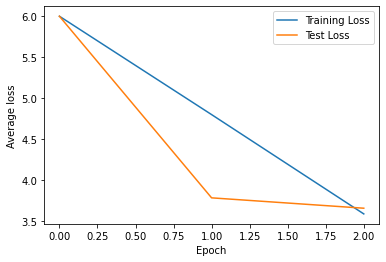

-------------------------------------------------------------------------------
Epoch starting at: 20:50:30
Epoch: 3, batch: 178/178, loss: 2.42374
Test Error:
Acc@1: 19.15%, Acc@5: 46.82%, Acc@10: 60.45%, Acc@20: 73.77% Avg loss: 3.652158
Epoch duration: 2:01


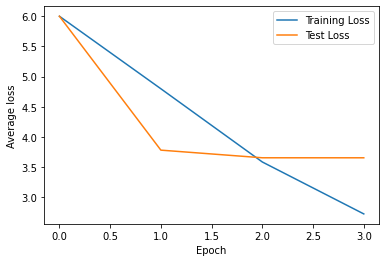





Current iteration 5/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 1000, batch_first=True)
  )
  (att_fc): Linear(in_features=1000, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=1108, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

------------------------------------------------------------

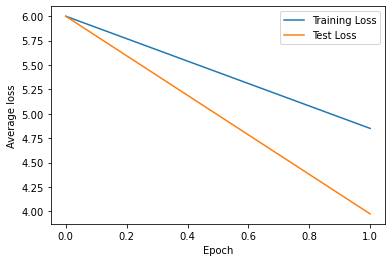

-------------------------------------------------------------------------------
Epoch starting at: 20:54:35
Epoch: 2, batch: 178/178, loss: 3.29315
Test Error:
Acc@1: 19.81%, Acc@5: 46.68%, Acc@10: 60.22%, Acc@20: 72.78% Avg loss: 3.654136
Epoch duration: 2:02


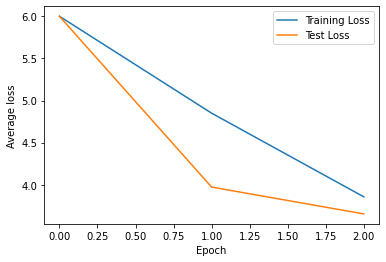

-------------------------------------------------------------------------------
Epoch starting at: 20:56:37
Epoch: 3, batch: 178/178, loss: 2.90927
Test Error:
Acc@1: 18.58%, Acc@5: 44.98%, Acc@10: 59.09%, Acc@20: 72.48% Avg loss: 3.703266
Epoch duration: 2:01


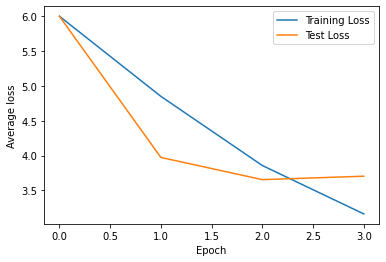





Current iteration 6/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 1000, batch_first=True)
  )
  (att_fc): Linear(in_features=1000, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1108, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

-------------------------------------------------------------

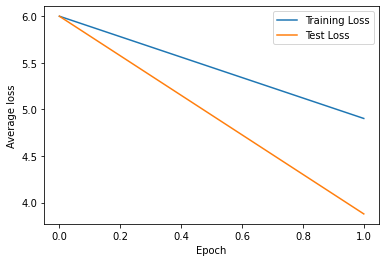

-------------------------------------------------------------------------------
Epoch starting at: 21:00:41
Epoch: 2, batch: 178/178, loss: 3.78446
Test Error:
Acc@1: 18.63%, Acc@5: 45.48%, Acc@10: 58.80%, Acc@20: 72.13% Avg loss: 3.757767
Epoch duration: 2:01


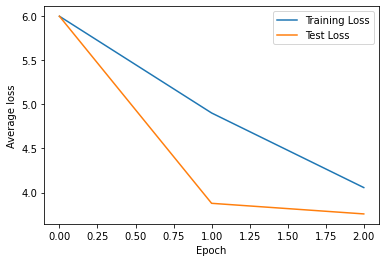

-------------------------------------------------------------------------------
Epoch starting at: 21:02:43
Epoch: 3, batch: 178/178, loss: 3.39198
Test Error:
Acc@1: 19.15%, Acc@5: 46.17%, Acc@10: 59.62%, Acc@20: 72.73% Avg loss: 3.707977
Epoch duration: 2:01


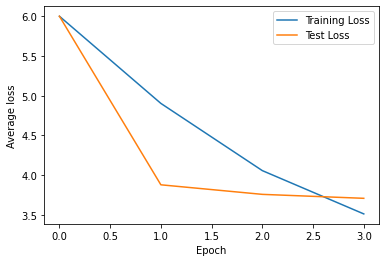





Current iteration 7/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 1000, batch_first=True)
  )
  (att_fc): Linear(in_features=1000, out_features=1, bias=True)
  (dropout): Dropout(p=0.75, inplace=False)
  (fc): Linear(in_features=1108, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

------------------------------------------------------------

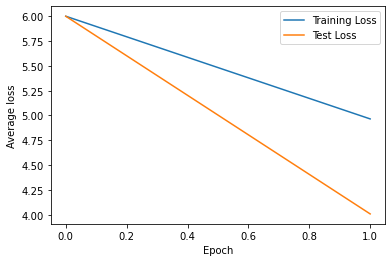

-------------------------------------------------------------------------------
Epoch starting at: 21:06:49
Epoch: 2, batch: 178/178, loss: 4.15045
Test Error:
Acc@1: 17.30%, Acc@5: 43.45%, Acc@10: 56.83%, Acc@20: 70.48% Avg loss: 3.874931
Epoch duration: 2:02


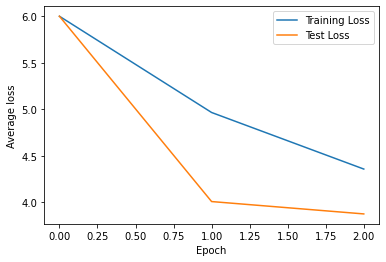

-------------------------------------------------------------------------------
Epoch starting at: 21:08:51
Epoch: 3, batch: 178/178, loss: 3.80515
Test Error:
Acc@1: 17.01%, Acc@5: 43.53%, Acc@10: 57.26%, Acc@20: 70.92% Avg loss: 3.845281
Epoch duration: 2:02


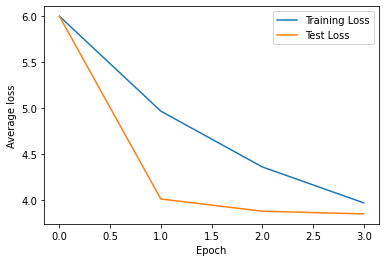





Current iteration 8/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 1500, batch_first=True)
  )
  (att_fc): Linear(in_features=1500, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=1608, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

---------------------------------------------------------------

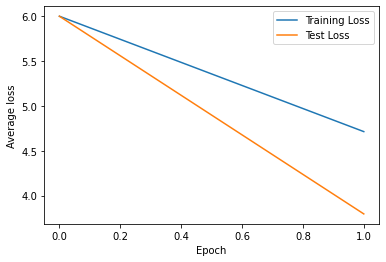

-------------------------------------------------------------------------------
Epoch starting at: 21:13:45
Epoch: 2, batch: 178/178, loss: 2.95049
Test Error:
Acc@1: 19.09%, Acc@5: 46.25%, Acc@10: 59.84%, Acc@20: 73.51% Avg loss: 3.669754
Epoch duration: 2:51


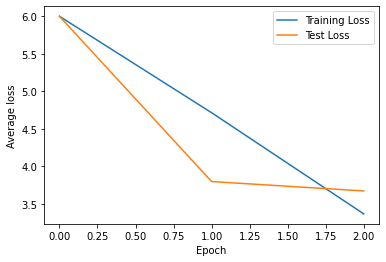

-------------------------------------------------------------------------------
Epoch starting at: 21:16:37
Epoch: 3, batch: 178/178, loss: 2.07948
Test Error:
Acc@1: 18.05%, Acc@5: 45.39%, Acc@10: 59.09%, Acc@20: 72.99% Avg loss: 3.734205
Epoch duration: 2:50


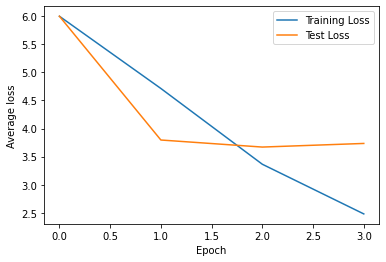





Current iteration 9/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 1500, batch_first=True)
  )
  (att_fc): Linear(in_features=1500, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=1608, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

------------------------------------------------------------

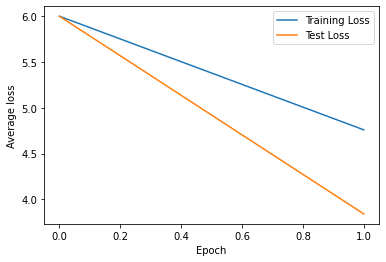

-------------------------------------------------------------------------------
Epoch starting at: 21:22:21
Epoch: 2, batch: 178/178, loss: 3.19574
Test Error:
Acc@1: 19.52%, Acc@5: 46.61%, Acc@10: 59.41%, Acc@20: 72.37% Avg loss: 3.667516
Epoch duration: 2:50


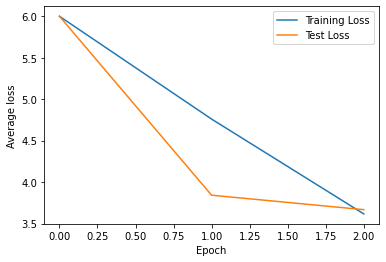

-------------------------------------------------------------------------------
Epoch starting at: 21:25:12
Epoch: 3, batch: 178/178, loss: 2.42493
Test Error:
Acc@1: 19.08%, Acc@5: 45.92%, Acc@10: 59.16%, Acc@20: 73.21% Avg loss: 3.679190
Epoch duration: 2:51


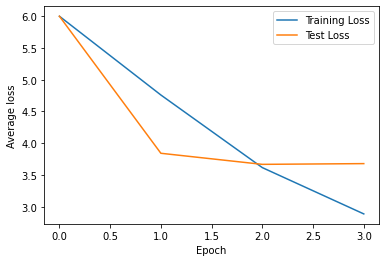





Current iteration 10/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 1500, batch_first=True)
  )
  (att_fc): Linear(in_features=1500, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1608, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

------------------------------------------------------------

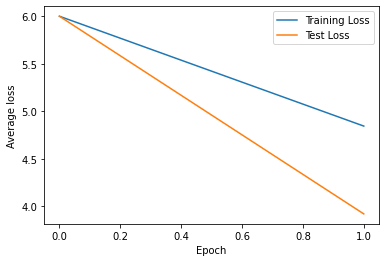

-------------------------------------------------------------------------------
Epoch starting at: 21:30:55
Epoch: 2, batch: 178/178, loss: 3.69134
Test Error:
Acc@1: 18.66%, Acc@5: 45.18%, Acc@10: 58.82%, Acc@20: 72.01% Avg loss: 3.745721
Epoch duration: 2:52


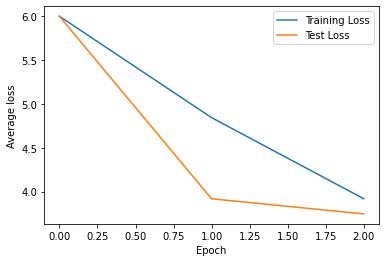

-------------------------------------------------------------------------------
Epoch starting at: 21:33:48
Epoch: 3, batch: 178/178, loss: 3.22816
Test Error:
Acc@1: 18.26%, Acc@5: 44.79%, Acc@10: 58.49%, Acc@20: 72.25% Avg loss: 3.742725
Epoch duration: 2:51


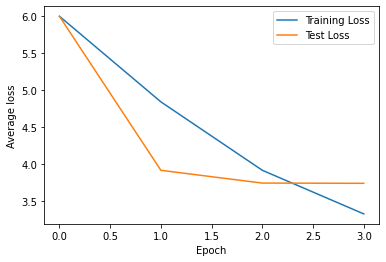





Current iteration 11/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 1500, batch_first=True)
  )
  (att_fc): Linear(in_features=1500, out_features=1, bias=True)
  (dropout): Dropout(p=0.75, inplace=False)
  (fc): Linear(in_features=1608, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

-----------------------------------------------------------

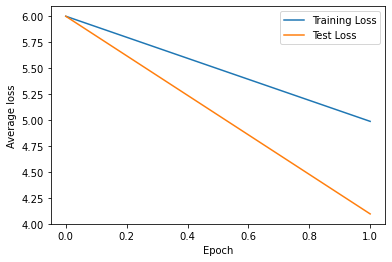

-------------------------------------------------------------------------------
Epoch starting at: 21:39:32
Epoch: 2, batch: 178/178, loss: 4.08382
Test Error:
Acc@1: 16.87%, Acc@5: 44.02%, Acc@10: 57.09%, Acc@20: 70.23% Avg loss: 3.915837
Epoch duration: 2:52


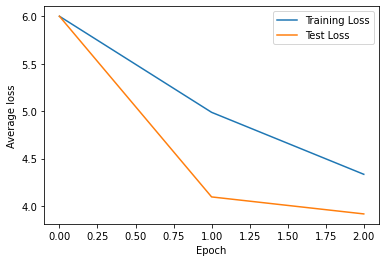

-------------------------------------------------------------------------------
Epoch starting at: 21:42:25
Epoch: 3, batch: 178/178, loss: 3.64712
Test Error:
Acc@1: 15.89%, Acc@5: 41.62%, Acc@10: 54.91%, Acc@20: 68.99% Avg loss: 3.895860
Epoch duration: 2:51


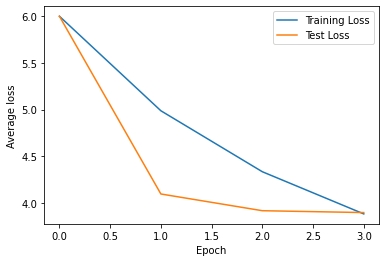





Current iteration 12/96
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2993, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (LSTMs): ModuleList(
    (0): LSTM(435, 2500, batch_first=True)
  )
  (att_fc): Linear(in_features=2500, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=2608, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

--------------------------------------------------------------

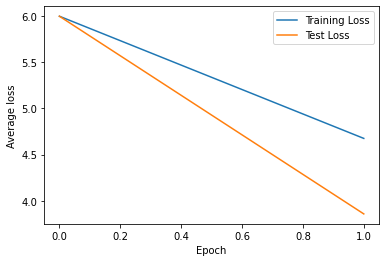

-------------------------------------------------------------------------------
Epoch starting at: 21:50:36
Epoch: 2, batch: 178/178, loss: 2.54271
Test Error:
Acc@1: 18.13%, Acc@5: 44.23%, Acc@10: 57.97%, Acc@20: 72.15% Avg loss: 3.733818
Epoch duration: 5:19


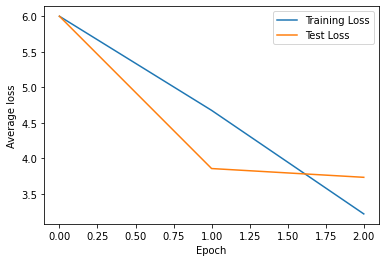

-------------------------------------------------------------------------------
Epoch starting at: 21:55:55


In [ ]:
num_epochs = 3
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-2, 1e-3, 1e-4][1:]
num_layers_values = [1, 10, 20]
hidden_sizes = [500, 1000, 1500, 2500]
dropout_probs = [0, 0.25, 0.5, 0.75]

try:            
    for learning_rate in learning_rates:
        for num_layers in num_layers_values:
            for hidden_size in hidden_sizes:
                for dropout_prob in dropout_probs:

                    lstm = HCPNN(num_classes=num_classes,
                                 input_size=num_features,
                                 num_layers=num_layers,
                                 hidden_size=hidden_size,
                                 dropout_prob=dropout_prob,
                                 skills=skills, 
                                 certs=certs,
                                 licenses=licenses,
                                 languages=languages,
                                 addresses=addresses,
                                 w2v=w2v,
                                 address_embedding_size=25,
                                 candidate_lengths=candidate_lens,
                                 max_len=max_len)

                    lstm = lstm.to(device)

                    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

                    if current >= 1:
                        print("\n\n\n")

                    print(f"Current iteration {current}/{len(learning_rates) * len(num_layers_values) * len(hidden_sizes) * len(dropout_probs)}")
                    print(f"- Initial learning rate: {learning_rate}\n- Model: \n\n", lstm, "\n")

                    trainloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                                            weight_type=3, batch_size=512)

                    # Store results of current configuration
                    outcome = train_loop(lstm, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
                    outcome["lr"] = [learning_rate] * num_epochs
                    outcome["Number of layers"] = [num_layers] * num_epochs
                    outcome["Nodes per layer"] = [hidden_size] * num_epochs

                    full_results.append(outcome)

                    with open("../results/LSTM.json", "w") as current_stats:
                        json.dump(full_results, current_stats)

                    current += 1
                    
except KeyboardInterrupt:
    pass

In [ ]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Number of layers", "Nodes per layer", "Epoch"])

In [ ]:
total

In [ ]:
total.to_csv("../results/LSTM-results.csv")

In [ ]:
switches = defaultdict(lambda: defaultdict(int))

for c, jobs in career_paths.iteritems():
    jobs = jobs[:,-1]
    for i in range(len(jobs)):
        if i < len(jobs) - 1 and jobs[i] != jobs[i + 1]:
            switches[jobs[i]][jobs[i  + 1]] += 1
            
most_common = {k: nlargest(1, v, key=v.get)[0] for k, v in switches.items()}

In [ ]:
with torch.no_grad():
    for candidate, career, job in valloader:
        career, job = career.to(device), job.to(device)
        pred, weight = lstm(candidate, career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())        
        print()
        
        # Check how often the model predicted the previous job + compare to baseline performance
        previous_job = torch.Tensor(career_paths.loc[candidate.cpu()].apply(lambda x: x[-2][-1]).values).to(device)
        print("Previous-job baseline accuracy:", (job == previous_job).cpu().numpy().mean())
        print("Majority class accuracy:", (job == majority_class).cpu().numpy().mean())
        print()
        
        print("Fraction of previous job predictions:", (pred.argmax(1) == previous_job).cpu().numpy().mean())
        print("Majority class predictions:", (pred.argmax(1) == majority_class).cpu().numpy().mean())
        print("Majority switch predictions:", np.mean([i.item() == most_common[i.item()] for i in pred.argmax(1).cpu().numpy()]))
                                                
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
        
        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
                
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
        
        plt.show()
        a = weight.cpu().detach().numpy().mean(axis=0)            
        plt.plot(a, label="average")
        # plt.plot(weights[0][np.random.choice(range(len(weights[0])))].cpu().detach().numpy(), label="random example")
        plt.xlabel("Career step")
        plt.ylabel("Attention weight")
        plt.show()
        
        break

In [ ]:
b = weight.cpu().detach().numpy()

for _ in range(20):
    c = np.random.randint(0, len(b))
    plt.plot(b[c])
    plt.xlabel("Career step")
    plt.ylabel("Attention weight")